In [61]:
import pandas as pd 
import numpy as np

import matplotlib.pyplot as plt

import xgboost as xgb
from sklearn.model_selection import train_test_split

from src.config import XGB_DATA_PATH

import wandb

In [62]:
# import data
df = pd.read_csv('C:/Users/Aqsone/Desktop/football-data/data/processed/clean_action_data.csv')
df_goal = pd.read_csv('C:/Users/Aqsone/Desktop/football-data/data/raw/freekick_pass_shot.csv')[['shot_statsbomb_xg', 'shot_outcome']]

df = df.merge(right = df_goal, on = 'shot_statsbomb_xg', how = 'left')
df['shot_outcome'] = np.where(df['shot_outcome'] == 'Goal', 1, 0)

C:\Users\Aqsone\AppData\Local\Temp\ipykernel_29500\2336622079.py:3: DtypeWarning: Columns (39,45,46,50,53,59,77,98,99,102,103,106,108,114,117) have mixed types. Specify dtype option on import or set low_memory=False.
  df_goal = pd.read_csv('C:/Users/Aqsone/Desktop/football-data/data/raw/freekick_pass_shot.csv')[['shot_statsbomb_xg', 'shot_outcome']]


In [63]:
# load model 
xgboost_model = xgb.XGBRegressor()
xgboost_model.load_model('xgb_few_var_10_players.json')  # Replace with the actual path to your model

In [64]:
# retrieve test set and apply predictions

cols_to_keep = ['shot_x', 'shot_y', 'fk_x', 'fk_y', 'pass_angle', 'distance_to_goal', 'shot_outcome'] 
k = 10
for i in range(1,k+1):
    cols_to_keep = cols_to_keep + [f'distance_player_{i}', f'angle_player_{i}', f'teammates_player_{i}']

_, X_test, _, y_test = train_test_split(df[cols_to_keep], df.shot_statsbomb_xg, test_size=0.25, random_state=42)

y_test_pred = xgboost_model.predict(X_test.drop('shot_outcome', axis = 1))
X_test['test_predictions'] = y_test_pred

In [65]:
print("Number of Goals in test set :", X_test.shot_outcome.sum(),' \n')
print("Sum of Statsbomb xG :", y_test.sum(),' \n')
print("Sum of Predicted xG :", X_test.test_predictions.sum(),' \n')

Number of Goals in test set : 77  

Sum of Statsbomb xG : 64.64388533709999  

Sum of Predicted xG : 60.630867  



In [66]:
X_test['xg'] = y_test
X_test = X_test[X_test.shot_outcome == 1].reset_index()

pos = 0
for i in range(len(X_test)):
    print(f"pred {X_test.test_predictions[i]} / sb_xg {X_test.xg[i]}")
    if X_test.test_predictions[i] >= X_test.xg[i]:
        pos+=1

print(pos)

pred 0.13250303268432617 / sb_xg 0.104610674
pred 0.05466374754905701 / sb_xg 0.054613724
pred 0.11308059096336365 / sb_xg 0.113309294
pred 0.05963308736681938 / sb_xg 0.11892551
pred 0.11499018222093582 / sb_xg 0.09197221
pred 0.24950434267520905 / sb_xg 0.23510946
pred 0.04563474282622337 / sb_xg 0.044501867
pred 0.17067816853523254 / sb_xg 0.20060822
pred 0.21852903068065643 / sb_xg 0.22282937
pred 0.3074132800102234 / sb_xg 0.3064361
pred 0.05960666015744209 / sb_xg 0.15803093
pred 0.18898580968379974 / sb_xg 0.17002814
pred 0.15874925255775452 / sb_xg 0.15919746
pred 0.14359566569328308 / sb_xg 0.12852617
pred 0.16111846268177032 / sb_xg 0.17107967
pred 0.07010336965322495 / sb_xg 0.077868916
pred 0.1435917615890503 / sb_xg 0.23358981
pred 0.038127750158309937 / sb_xg 0.032802735
pred 0.25256773829460144 / sb_xg 0.25327495
pred 0.07284509390592575 / sb_xg 0.20974502
pred 0.1842469871044159 / sb_xg 0.14189544
pred 0.19428937137126923 / sb_xg 0.2340423
pred 0.21197757124900818 / sb_

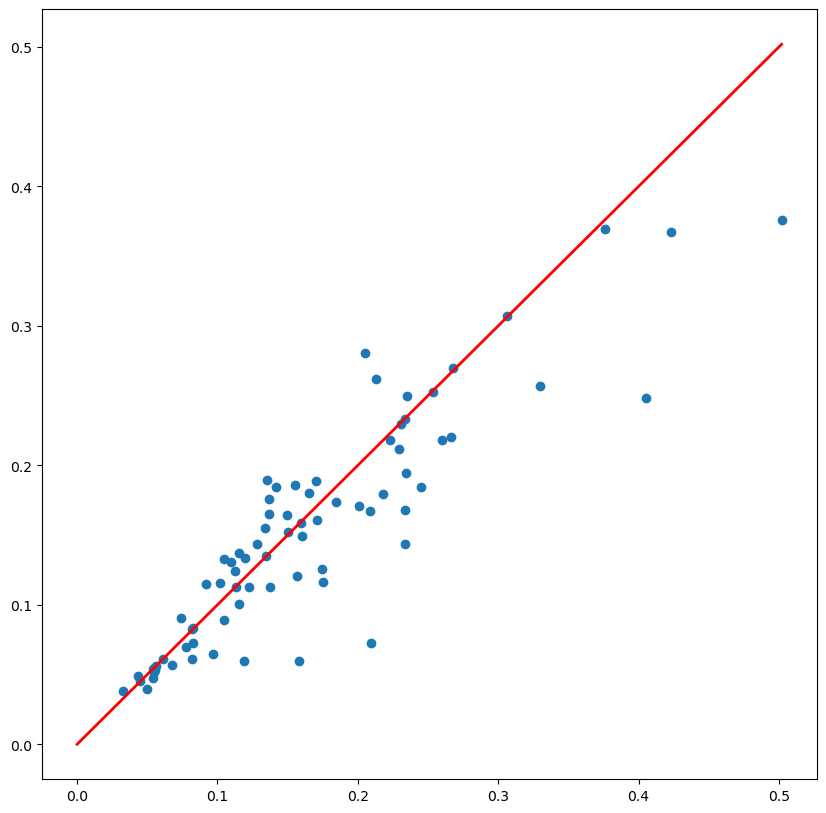

In [47]:
plt.figure(figsize = (10,10))
plt.scatter(X_test.xg, X_test.test_predictions)
max = np.max(X_test.xg)
plt.plot([0, max], [0, max], color='red', linestyle='-', linewidth=2)